In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qulacs import DensityMatrix
from qulacs.state import partial_trace, tensor_product
from qulacs.gate import H, CNOT, RX, PauliRotation, DepolarizingNoise

In [2]:
def noisy_Z_evolution(rho_input, n_qubit, theta, p_err):
    rho = rho_input.copy()

    for n in range(n_qubit // 2):
        PauliRotation([2*n, 2*n+1], [3, 3], theta).update_quantum_state(rho)
    for n in range(n_qubit // 2 - 1):
        PauliRotation([2*n+1, 2*n+2], [3, 3], theta).update_quantum_state(rho)

    for n in range(n_qubit):
        DepolarizingNoise(n, p_err).update_quantum_state(rho)
    
    return rho

def noisy_X_evolution(rho_input, n_qubit, theta, p_err):
    rho = rho_input.copy()

    for n in range(n_qubit):
        RX(n, theta).update_quantum_state(rho)
        DepolarizingNoise(n, p_err).update_quantum_state(rho)
    
    return rho


def noisy_time_evolution(rho_input, n_qubit, layer, theta_list, p_err):
    rho = rho_input.copy()

    for l in range(layer):
        rho = noisy_Z_evolution(rho, n_qubit, theta_list, p_err)
        rho = noisy_X_evolution(rho, n_qubit, theta_list, p_err)

    return rho


def symmetry_verification(rho_input, n_qubit, layer, theta_list, p_err):
    rho = rho_input.copy()

    # U
    for l in range(layer):
        rho = noisy_Z_evolution(rho, n_qubit, theta_list, p_err)
        rho = noisy_X_evolution(rho, n_qubit, theta_list, p_err)

    # measurement
    rho_ancilla = DensityMatrix(1)
    rho = tensor_product(rho_ancilla, rho)

    H(n_qubit).update_quantum_state(rho)
    for n in range(n_qubit):
        CNOT(n_qubit, n).update_quantum_state(rho)
    H(n_qubit).update_quantum_state(rho)

    completely_mixed_state = DensityMatrix(n_qubit)
    completely_mixed_state.load(np.identity(2**n_qubit))
    projector = tensor_product(DensityMatrix(1), completely_mixed_state)
    
    rho_matrix = projector.get_matrix() @ rho.get_matrix() @ projector.get_matrix()
    rho.load(rho_matrix)
    rho = partial_trace(rho, [n_qubit])

    return rho



def symmetric_channel_verification(rho_input, n_qubit, layer, theta, p_err, gadget_error_ratio=100, with_ancilla_noise = False):
    p_err_gadget = p_err / gadget_error_ratio
    n_ancilla = n_qubit+1
    rho = rho_input.copy()

    for n in range(n_ancilla):
        rho_ancilla = DensityMatrix(1)
        rho = tensor_product(rho_ancilla, rho)

    for l in range(layer):
        # Z evolution
        # U_E
        for n in range(n_qubit+n_ancilla):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)

        H(2*n_qubit).update_quantum_state(rho)
        for n in range(n_qubit):
            CNOT(2*n_qubit, n).update_quantum_state(rho)

        for n in range(n_qubit):
            CNOT(n, n+n_qubit).update_quantum_state(rho)

        # U
        rho = noisy_Z_evolution(rho, n_qubit, theta, p_err)

        if with_ancilla_noise:
            for n in range(n_ancilla):
                DepolarizingNoise(n+n_qubit, p_err).update_quantum_state(rho)

        # U_D
        for n in range(n_qubit):
            CNOT(n, n+n_qubit).update_quantum_state(rho)
        
        for n in range(n_qubit):
            CNOT(2*n_qubit, n).update_quantum_state(rho)
        H(2*n_qubit).update_quantum_state(rho)

        for n in range(n_qubit+n_ancilla):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)
        
        # measurement
        completely_mixed_state = DensityMatrix(n_qubit)
        completely_mixed_state.load(np.identity(2**n_qubit))
        projector = tensor_product(DensityMatrix(n_ancilla), completely_mixed_state)

        rho_matrix = projector.get_matrix() @ rho.get_matrix() @ projector.get_matrix()
        rho.load(rho_matrix)


        # X evolution
        # U_E
        for n in range(n_qubit+n_ancilla-1):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)

        for n in range(n_qubit):
            H(n+n_qubit).update_quantum_state(rho)
            CNOT(n+n_qubit, n).update_quantum_state(rho)

        # U
        rho = noisy_X_evolution(rho, n_qubit, theta, p_err)

        if with_ancilla_noise:
            for n in range(n_ancilla-1):
                DepolarizingNoise(n+n_qubit, p_err).update_quantum_state(rho)
        
        # U_D
        for n in range(n_qubit):
            CNOT(n+n_qubit, n).update_quantum_state(rho)
            H(n+n_qubit).update_quantum_state(rho)

        for n in range(n_qubit+n_ancilla-1):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)

        # measurement
        completely_mixed_state = DensityMatrix(n_qubit)
        completely_mixed_state.load(np.identity(2**n_qubit))
        projector = tensor_product(DensityMatrix(n_ancilla), completely_mixed_state)

        rho_matrix = projector.get_matrix() @ rho.get_matrix() @ projector.get_matrix()
        rho.load(rho_matrix)

    rho = partial_trace(rho, [n_qubit+i for i in range(n_ancilla)])

    return rho





def symmetric_channel_verification_flag(rho_input, n_qubit, layer, theta, p_err, gadget_error_ratio=100, with_ancilla_noise = True):
    p_err_gadget = p_err / gadget_error_ratio
    n_ancilla = (n_qubit+1)*2
    rho = rho_input.copy()

    for n in range(n_ancilla):
        rho_ancilla = DensityMatrix(1)
        rho = tensor_product(rho_ancilla, rho)

    for l in range(layer):
        # Z evolution
        # U_E
        for n in range(n_qubit+n_ancilla):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)

        H(2*n_qubit).update_quantum_state(rho)
        for n in range(n_qubit):
            CNOT(2*n_qubit, n).update_quantum_state(rho)
        CNOT(2*n_qubit, 3*n_qubit+1).update_quantum_state(rho)

        for n in range(n_qubit):
            CNOT(n, n+n_qubit).update_quantum_state(rho)
            H(n+2*n_qubit+1).update_quantum_state(rho)
            CNOT(n+2*n_qubit+1, n+n_qubit).update_quantum_state(rho)

        # U
        rho = noisy_Z_evolution(rho, n_qubit, theta, p_err)

        if with_ancilla_noise:
            for n in range(n_ancilla):
                DepolarizingNoise(n+n_qubit, p_err).update_quantum_state(rho)

        # U_D
        for n in range(n_qubit):
            CNOT(n+2*n_qubit+1, n+n_qubit).update_quantum_state(rho)
            H(n+2*n_qubit+1).update_quantum_state(rho)
            CNOT(n, n+n_qubit).update_quantum_state(rho)
        
        CNOT(2*n_qubit, 3*n_qubit+1).update_quantum_state(rho)
        for n in range(n_qubit):
            CNOT(2*n_qubit, n).update_quantum_state(rho)
        H(2*n_qubit).update_quantum_state(rho)

        for n in range(n_qubit+n_ancilla):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)

        # measurement
        completely_mixed_state = DensityMatrix(n_qubit)
        completely_mixed_state.load(np.identity(2**n_qubit))
        projector = tensor_product(DensityMatrix(n_ancilla), completely_mixed_state)

        rho_matrix = projector.get_matrix() @ rho.get_matrix() @ projector.get_matrix()
        rho.load(rho_matrix)


        # X evolution
        # U_E
        for n in range(n_qubit+n_ancilla-2):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)
            
        for n in range(n_qubit):
            H(n+n_qubit).update_quantum_state(rho)
            CNOT(n+n_qubit, n).update_quantum_state(rho)
            CNOT(n+n_qubit, n+2*n_qubit).update_quantum_state(rho)

        # U
        rho = noisy_X_evolution(rho, n_qubit, theta, p_err)

        if with_ancilla_noise:
            for n in range(n_ancilla-2):
                DepolarizingNoise(n+n_qubit, p_err).update_quantum_state(rho)

        # U_D
        for n in range(n_qubit):
            CNOT(n+n_qubit, n+2*n_qubit).update_quantum_state(rho)
            CNOT(n+n_qubit, n).update_quantum_state(rho)
            H(n+n_qubit).update_quantum_state(rho)

        for n in range(n_qubit+n_ancilla-2):
            DepolarizingNoise(n, p_err_gadget).update_quantum_state(rho)

        # measurement
        completely_mixed_state = DensityMatrix(n_qubit)
        completely_mixed_state.load(np.identity(2**n_qubit))
        projector = tensor_product(DensityMatrix(n_ancilla), completely_mixed_state)

        rho_matrix = projector.get_matrix() @ rho.get_matrix() @ projector.get_matrix()
        rho.load(rho_matrix)

    rho = partial_trace(rho, [n_qubit+i for i in range(n_ancilla)])

    return rho

In [3]:
n_qubit = 4
layer = 100
p_err_list = np.array([1, 2, 5, 10, 20, 50, 100]) * 10**(-5)
theta = 2 * np.pi / layer

tracedist_noisy_list = np.zeros(len(p_err_list))
tracedist_state_list = np.zeros(len(p_err_list))
tracedist_channel_list = np.zeros(len(p_err_list))

for p_index, p_err in enumerate(p_err_list):
    rho_initial = DensityMatrix(n_qubit)
    for n in range(n_qubit):
        H(n).update_quantum_state(rho_initial)

    rho_ideal = noisy_time_evolution(rho_initial, n_qubit, layer, theta, 0)
    rho_noisy = noisy_time_evolution(rho_initial, n_qubit, layer, theta, p_err)
    rho_state = symmetry_verification(rho_initial, n_qubit, layer, theta, p_err)
    rho_channel = symmetric_channel_verification(rho_initial, n_qubit, layer, theta, p_err)

    rho_ideal = rho_ideal.get_matrix()
    rho_noisy = rho_noisy.get_matrix()
    rho_state = rho_state.get_matrix()
    rho_channel = rho_channel.get_matrix()

    tracedist_noisy_list[p_index] = np.linalg.norm(rho_ideal - rho_noisy, ord = 'nuc') / 2
    tracedist_state_list[p_index] = np.linalg.norm(rho_ideal - rho_state / np.trace(rho_state), ord = 'nuc') / 2
    tracedist_channel_list[p_index] = np.linalg.norm(rho_ideal - rho_channel / np.trace(rho_channel), ord = 'nuc') / 2

    print(p_index)

0
1
2
3
4
5
6


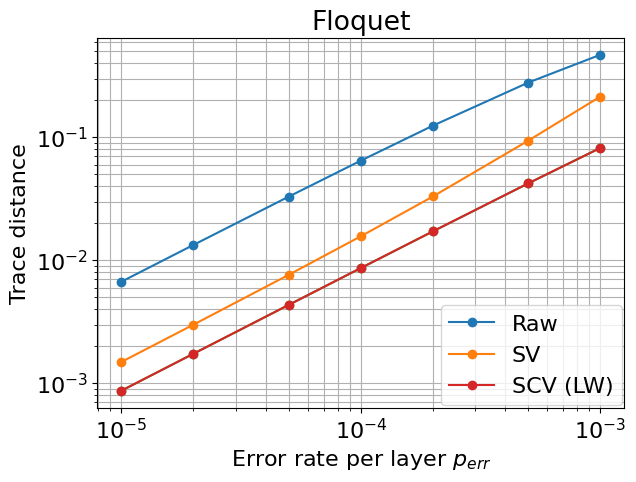

In [ ]:
plt.rcParams['figure.figsize'] = [6.8, 4.8]
plt.rcParams["font.size"] = 16

plt.plot(p_err_list, tracedist_noisy_list, marker = 'o', label = 'Raw')
plt.plot(p_err_list, tracedist_state_list, marker = 'o', label = 'SV')
plt.plot(p_err_list, tracedist_channel_list, marker = 'o')
plt.plot(p_err_list, tracedist_channel_list, marker = 'o', label = 'SCV (LW)')

plt.xscale('log')
plt.yscale('log')
plt.title('Floquet')
plt.xlabel('Error rate per layer $p_{err}$')
plt.ylabel('Trace distance')
plt.legend(bbox_to_anchor=(1,0),loc='lower right',borderaxespad=0.1,)
plt.grid(which='both', axis='both')
#plt.savefig('Floquet.pdf', bbox_inches='tight')

In [3]:
n_qubit = 2
layer = 100
p_err_list = np.array([1, 2, 5, 10, 20, 50, 100]) * 10**(-5)
theta = 2 * np.pi / 100

tracedist_noisy_list = np.zeros(len(p_err_list))
tracedist_state_list = np.zeros(len(p_err_list))
tracedist_channel_list = np.zeros(len(p_err_list))
tracedist_channel_noisy_list = np.zeros(len(p_err_list))
tracedist_channel_flag_list = np.zeros(len(p_err_list))

for p_index, p_err in enumerate(p_err_list):
    rho_initial = DensityMatrix(n_qubit)
    for n in range(n_qubit):
        H(n).update_quantum_state(rho_initial)

    rho_ideal = noisy_time_evolution(rho_initial, n_qubit, layer, theta, 0)
    rho_noisy = noisy_time_evolution(rho_initial, n_qubit, layer, theta, p_err)
    rho_state = symmetry_verification(rho_initial, n_qubit, layer, theta, p_err)
    rho_channel = symmetric_channel_verification(rho_initial, n_qubit, layer, theta, p_err, with_ancilla_noise=False)
    rho_channel_noisy = symmetric_channel_verification(rho_initial, n_qubit, layer, theta, p_err, with_ancilla_noise=True)
    rho_channel_flag = symmetric_channel_verification_flag(rho_initial, n_qubit, layer, theta, p_err, with_ancilla_noise=True)

    rho_ideal = rho_ideal.get_matrix()
    rho_noisy = rho_noisy.get_matrix()
    rho_state = rho_state.get_matrix()
    rho_channel = rho_channel.get_matrix()
    rho_channel_noisy = rho_channel_noisy.get_matrix()
    rho_channel_flag = rho_channel_flag.get_matrix()

    tracedist_noisy_list[p_index] = np.linalg.norm(rho_ideal - rho_noisy, ord = 'nuc') / 2
    tracedist_state_list[p_index] = np.linalg.norm(rho_ideal - rho_state / np.trace(rho_state), ord = 'nuc') / 2
    tracedist_channel_list[p_index] = np.linalg.norm(rho_ideal - rho_channel / np.trace(rho_channel), ord = 'nuc') / 2
    tracedist_channel_noisy_list[p_index] = np.linalg.norm(rho_ideal - rho_channel_noisy / np.trace(rho_channel_noisy), ord = 'nuc') / 2
    tracedist_channel_flag_list[p_index] = np.linalg.norm(rho_ideal - rho_channel_flag / np.trace(rho_channel_flag), ord = 'nuc') / 2

    print(p_index)

0
1
2
3
4
5
6


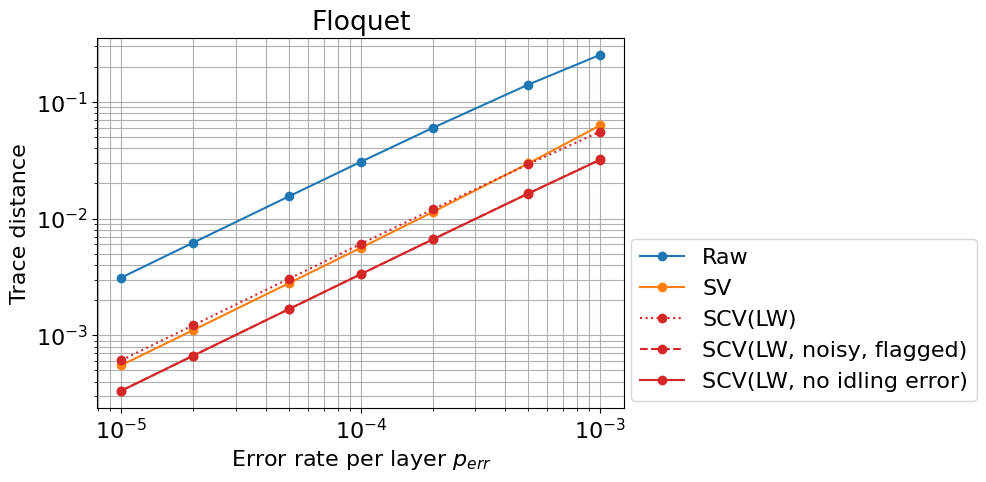

In [ ]:
plt.rcParams['figure.figsize'] = [6.8, 4.8]
plt.rcParams["font.size"] = 16

plt.plot(p_err_list, tracedist_noisy_list, marker = 'o', label = 'Raw')
plt.plot(p_err_list, tracedist_state_list, marker = 'o', label = 'SV')
plt.plot(p_err_list, tracedist_channel_noisy_list, marker = 'o', color = 'tab:red', linestyle = ':', label = 'SCV(LW)')
plt.plot(p_err_list, tracedist_channel_flag_list, marker = 'o', color = 'tab:red', linestyle = '--', label = 'SCV(LW, noisy, flagged)')
plt.plot(p_err_list, tracedist_channel_list, marker = 'o', color = 'tab:red', linestyle = '-', label = 'SCV(LW, no idling error)')

plt.xscale('log')
plt.yscale('log')
plt.title('Floquet')
plt.xlabel('Error rate per layer $p_{err}$')
plt.ylabel('Trace distance')
plt.legend(bbox_to_anchor=(1,0),loc='lower left',borderaxespad=0.3)
plt.grid(which='both', axis='both')
#plt.savefig('Floquet_flag.pdf', bbox_inches='tight')

In [6]:
n_qubit = 2
layer = 100
p_err_list = np.array([1, 2, 5, 10, 20, 50, 100]) * 10**(-5)
theta = 2 * np.pi / 100

tracedist_noisy_list = np.zeros(len(p_err_list))
tracedist_state_list = np.zeros(len(p_err_list))
tracedist_channel_FTQC_list = np.zeros(len(p_err_list))
tracedist_channel_NISQ_list = np.zeros(len(p_err_list))

for p_index, p_err in enumerate(p_err_list):
    rho_initial = DensityMatrix(n_qubit)
    for n in range(n_qubit):
        H(n).update_quantum_state(rho_initial)

    rho_ideal = noisy_time_evolution(rho_initial, n_qubit, layer, theta, 0)
    rho_noisy = noisy_time_evolution(rho_initial, n_qubit, layer, theta, p_err)
    rho_state = symmetry_verification(rho_initial, n_qubit, layer, theta, p_err)
    rho_channel_FTQC = symmetric_channel_verification_flag(rho_initial, n_qubit, layer, theta, p_err, gadget_error_ratio=100, with_ancilla_noise=True)
    rho_channel_NISQ = symmetric_channel_verification_flag(rho_initial, n_qubit, layer, theta, p_err, gadget_error_ratio=1, with_ancilla_noise=True)

    rho_ideal = rho_ideal.get_matrix()
    rho_noisy = rho_noisy.get_matrix()
    rho_state = rho_state.get_matrix()
    rho_channel_FTQC = rho_channel_FTQC.get_matrix()
    rho_channel_NISQ = rho_channel_NISQ.get_matrix()

    tracedist_noisy_list[p_index] = np.linalg.norm(rho_ideal - rho_noisy, ord = 'nuc') / 2
    tracedist_state_list[p_index] = np.linalg.norm(rho_ideal - rho_state / np.trace(rho_state), ord = 'nuc') / 2
    tracedist_channel_FTQC_list[p_index] = np.linalg.norm(rho_ideal - rho_channel_FTQC / np.trace(rho_channel_FTQC), ord = 'nuc') / 2
    tracedist_channel_NISQ_list[p_index] = np.linalg.norm(rho_ideal - rho_channel_NISQ / np.trace(rho_channel_NISQ), ord = 'nuc') / 2

    print(p_index)

0
1
2
3
4
5
6


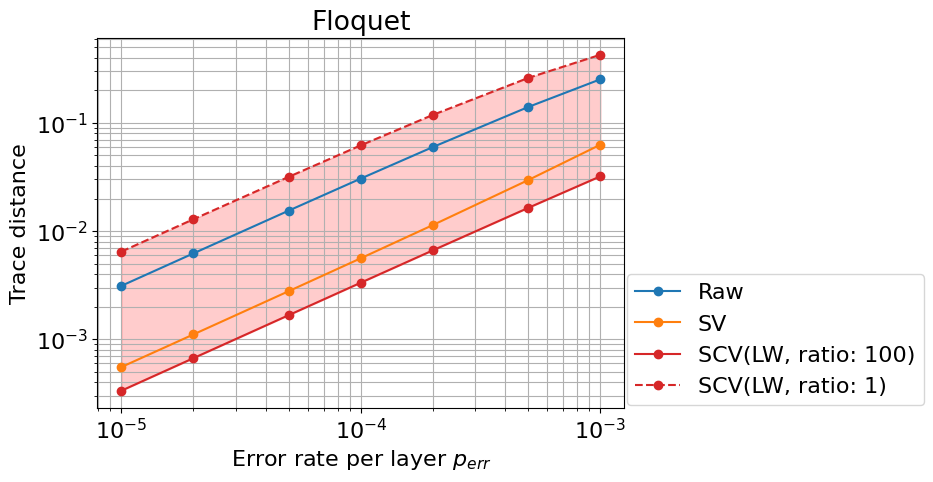

In [ ]:
plt.rcParams['figure.figsize'] = [6.8, 4.8]
plt.rcParams["font.size"] = 16

plt.plot(p_err_list, tracedist_noisy_list, marker = 'o', label = 'Raw')
plt.plot(p_err_list, tracedist_state_list, marker = 'o', label = 'SV')
plt.plot(p_err_list, tracedist_channel_FTQC_list, marker = 'o', color = 'tab:red', linestyle = '-', label = 'SCV(LW, ratio: 100)')
plt.plot(p_err_list, tracedist_channel_NISQ_list, marker = 'o', color = 'tab:red', linestyle = '--', label = 'SCV(LW, ratio: 1)')

plt.fill_between(
    p_err_list,
    tracedist_channel_FTQC_list,
    tracedist_channel_NISQ_list,
    color='red',
    alpha=0.2
)

plt.xscale('log')
plt.yscale('log')
plt.title('Floquet')
plt.xlabel('Error rate per layer $p_{err}$')
plt.ylabel('Trace distance')
plt.legend(bbox_to_anchor=(1,0),loc='lower left',borderaxespad=0.1,)
plt.grid(which='both', axis='both')

#plt.savefig('Floquet_NISQ.pdf', bbox_inches='tight')